In [28]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, accuracy_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.isotonic import IsotonicRegression
import numpy as np
from scipy import interpolate


In [6]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
# Load datasets
train_data = ImageFolder(root='/Users/surajdhulipalla/Documents/SeniorSpring/BME436/GalvoSoftware/SkinCancerDiagnostic/melanoma_cancer_dataset/train', transform=transform)
test_data = ImageFolder(root='/Users/surajdhulipalla/Documents/SeniorSpring/BME436/GalvoSoftware/SkinCancerDiagnostic/melanoma_cancer_dataset/test', transform=transform)


In [9]:
# Data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

In [10]:
# Define the CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 64 * 64, 256)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch dimension
        x = self.act3(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
# Initialize the network
net = SimpleCNN().to(device)

In [12]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [14]:
# Training the network
def train(num_epochs):
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        with tqdm(train_loader, unit="batch") as tepoch:
            for inputs, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch + 1}")
                
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                tepoch.set_postfix(loss=running_loss / len(tepoch))


In [15]:
# Testing the network
def test():
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as ttest:
            for images, labels in ttest:
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                ttest.set_postfix(accuracy=f'{100 * correct / total:.2f}%')

    print(f'Accuracy of the network on the test images: {100 * correct / total}%')

In [16]:
train(num_epochs=10)
test()

100%|██████████| 32/32 [00:33<00:00,  1.04s/batch, accuracy=90.50%]

Accuracy of the network on the test images: 90.5%


In [29]:
def test_more():
    net.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)

    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'Confusion Matrix:\n{cm}')

    # Sensitivity and Specificity calculations
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    sensitivity = TP / (TP + FN)  # Same as recall
    specificity = TN / (TN + FP)

    print("Sensitivity: {}".format(sensitivity))
    print("Specificity: {}".format(specificity))

    # Compute ROC AUC and PR AUC if applicable
    if len(set(all_labels)) > 2:
        roc_auc = roc_auc_score(all_labels, all_preds, multi_class='ovr')
        print(f'ROC AUC: {roc_auc:.2f}')
    else:
        roc_auc = roc_auc_score(all_labels, all_preds)
        precisions, recalls, _ = precision_recall_curve(all_labels, all_preds)
        pr_auc = auc(recalls, precisions)
        print(f'ROC AUC: {roc_auc:.2f}')
        print(f'Precision-Recall AUC: {pr_auc:.2f}')
        iso_reg = IsotonicRegression(out_of_bounds='clip')
        all_outputs_calibrated = iso_reg.fit_transform(all_preds, all_labels)
        # Compute ROC curve and ROC area
        fpr, tpr, thresholds = roc_curve(all_labels, all_outputs_calibrated)
        roc_auc = auc(fpr, tpr)
        print(thresholds)

        # Create an interpolation function based on the fpr, tpr
        tpr_interp = interpolate.interp1d(fpr, tpr, kind='linear')
        fpr_fine = np.linspace(0, 1, 300)  # Creating a fine resolution of FPR values
        tpr_smooth = tpr_interp(fpr_fine)  # Use interpolation function to calculate smooth TPR

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr_fine, tpr_smooth, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    
    return precision, recall, f1, cm, accuracy

Accuracy: 0.91
Precision: 0.93
Recall: 0.87
F1 Score: 0.90
Confusion Matrix:
[[469  31]
 [ 64 436]]
Sensitivity: 0.872
Specificity: 0.938
ROC AUC: 0.90
Precision-Recall AUC: 0.93
[       inf 0.93361884 0.12007505]


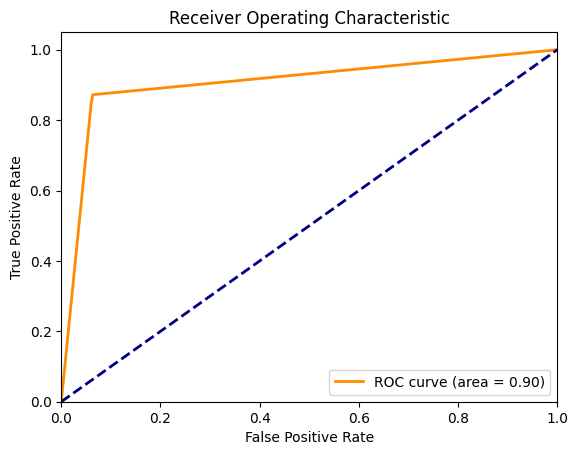

(0.9336188436830836,
 0.872,
 0.9017580144777663,
 array([[469,  31],
        [ 64, 436]]),
 0.905)

In [30]:
test_more()